### Importing and Reading HI-Small_Trans.csv

In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv('HI-Small_Trans.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [4]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [5]:
df['Payment Currency'].value_counts()

US Dollar            1895172
Euro                 1168297
Swiss Franc           234860
Yuan                  213752
Shekel                192184
Rupee                 190202
UK Pound              180738
Yen                   155209
Ruble                 155178
Bitcoin               146066
Canadian Dollar       140042
Australian Dollar     136769
Mexican Peso          110159
Saudi Riyal            89014
Brazil Real            70703
Name: Payment Currency, dtype: int64

In [6]:
df['Is Laundering'].value_counts(normalize=True)


0    0.998981
1    0.001019
Name: Is Laundering, dtype: float64

### Feature Transformation

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
currency_conversion_rates = {
    'US Dollar': 1.0,
    'Euro': 1.03, 
    'Swiss Franc': 1.09, 
    'Yuan': 0.14, 
    'Shekel': 0.28,
    'Rupee': 0.012, 
    'UK Pound': 1.24, 
    'Yen': 0.0066, 
    'Ruble': 0.01, 
    'Bitcoin': 95781.21,
    'Canadian Dollar': 0.7, 
    'Australian Dollar': 0.63, 
    'Mexican Peso': 0.049, 
    'Saudi Riyal': 0.27, 
    'Brazil Real': 0.17
}

df['Amount Paid (USD)'] = df.apply(lambda row: row['Amount Paid'] * currency_conversion_rates.get(row['Payment Currency'], 1), axis=1)
df['Amount Received (USD)'] = df.apply(lambda row: row['Amount Received'] * currency_conversion_rates.get(row['Receiving Currency'], 1), axis=1)

In [9]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['year'] = df['Timestamp'].dt.year  
df['month'] = df['Timestamp'].dt.month  
df['day'] = df['Timestamp'].dt.day  
df['hour'] = df['Timestamp'].dt.hour
df['second'] = df['Timestamp'].dt.second 

df.drop(columns=['Timestamp','Amount Paid','Amount Received' ], inplace=True)

cat_col = ['From Bank', 'Account', 'To Bank', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']
for col in cat_col:
    df[col] = LabelEncoder().fit_transform(df[col])


In [10]:
df.head()

,From Bank,Account,To Bank,Account.1,Receiving Currency,Payment Currency,Payment Format,Is Laundering,Amount Paid (USD),Amount Received (USD),year,month,day,hour,second
0,8,942,8,900,12,12,5,0,3697.34,3697.34,2022,9,1,0,0
1,109,990,0,949,12,12,3,0,0.01,0.01,2022,9,1,0,0
2,110,991,106,940,12,12,5,0,14675.57,14675.57,2022,9,1,0,0
3,10,997,10,945,12,12,5,0,2806.97,2806.97,2022,9,1,0,0
4,8,999,8,947,12,12,5,0,36682.97,36682.97,2022,9,1,0,0


### Training a Baseline ML Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

In [12]:
import networkx as nx

G = nx.DiGraph()

for _, row in df.iterrows():
    G.add_edge(row['Account'], row['Account.1'], weight=row['Amount Paid (USD)'])

df['degree_centrality'] = df['Account'].map(nx.degree_centrality(G))
df['pagerank'] = df['Account'].map(nx.pagerank(G))


In [13]:
df.head()

,From Bank,Account,To Bank,Account.1,Receiving Currency,Payment Currency,Payment Format,Is Laundering,Amount Paid (USD),Amount Received (USD),year,month,day,hour,second,degree_centrality,pagerank
0,8,942,8,900,12,12,5,0,3697.34,3697.34,2022,9,1,0,0,0.000012,1.373167e-06
1,109,990,0,949,12,12,3,0,0.01,0.01,2022,9,1,0,0,0.000008,3.783561e-07
2,110,991,106,940,12,12,5,0,14675.57,14675.57,2022,9,1,0,0,0.000004,2.091255e-06
3,10,997,10,945,12,12,5,0,2806.97,2806.97,2022,9,1,0,0,0.000008,3.542830e-06
4,8,999,8,947,12,12,5,0,36682.97,36682.97,2022,9,1,0,0,0.000016,7.287749e-07


In [14]:
# Convert numerical features into tensors
feature_cols = ["Amount Paid (USD)", "Amount Received (USD)", "year", "month", "day", "hour", "second",
                "degree_centrality", "pagerank"]

node_features = torch.tensor(df[feature_cols].values, dtype=torch.float)

# Convert labels to tensor (1 = Money laundering, 0 = Legitimate)
labels = torch.tensor(df["Is Laundering"].values, dtype=torch.long)

# Create edge index for PyTorch Geometric (source → destination)
edge_index = torch.tensor(df[["Account", "Account.1"]].values.T, dtype=torch.long)

# Create PyG Data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

# Print PyG data structure
print(data)

Data(x=[5078345, 9], edge_index=[2, 5078345], y=[5078345])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


In [16]:
# Define the Enhanced GNN Model
class EnhancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(EnhancedGNN, self).__init__()

        # Initial Graph Convolutional Layer (GCN)
        self.gcn1 = GCNConv(input_dim, hidden_dim)

        # Graph Attention Layer (GAT)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=False)

        # Fully Connected Layer for Node Classification
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        # Apply GCN
        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        # Apply GAT for attention-based feature learning
        x = self.gat1(x, edge_index)
        x = F.relu(x)

        # Fully connected layers for **node-level classification**
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)  # Log Softmax for Multi-class Classification

In [17]:
# Instantiate the model
model = EnhancedGNN(input_dim=node_features.shape[1], hidden_dim=16, output_dim=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [18]:
# Move data to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")


Epoch 0 - Loss: 31.4639
Epoch 10 - Loss: 0.3019
Epoch 20 - Loss: 0.1719
Epoch 30 - Loss: 0.1050
Epoch 40 - Loss: 0.1066
Epoch 50 - Loss: 0.0824
Epoch 60 - Loss: 0.0929
Epoch 70 - Loss: 0.0894
Epoch 80 - Loss: 0.0823
Epoch 90 - Loss: 0.0740


In [19]:
df_test = pd.read_csv('LI-Small_Trans.csv')

df_test['Amount Paid (USD)'] = df_test.apply(lambda row: row['Amount Paid'] * currency_conversion_rates.get(row['Payment Currency'], 1), axis=1)
df_test['Amount Received (USD)'] = df_test.apply(lambda row: row['Amount Received'] * currency_conversion_rates.get(row['Receiving Currency'], 1), axis=1)


df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

df_test['year'] = df_test['Timestamp'].dt.year  
df_test['month'] = df_test['Timestamp'].dt.month  
df_test['day'] = df_test['Timestamp'].dt.day  
df_test['hour'] = df_test['Timestamp'].dt.hour
df_test['second'] = df_test['Timestamp'].dt.second 

df_test.drop(columns=['Timestamp','Amount Paid','Amount Received' ], inplace=True)

cat_col = ['From Bank', 'Account', 'To Bank', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']
for col in cat_col:
    df_test[col] = LabelEncoder().fit_transform(df_test[col])

import networkx as nx

G = nx.DiGraph()

for _, row in df_test.iterrows():
    G.add_edge(row['Account'], row['Account.1'], weight=row['Amount Paid (USD)'])

df_test['degree_centrality'] = df_test['Account'].map(nx.degree_centrality(G))
df_test['pagerank'] = df_test['Account'].map(nx.pagerank(G))

# Convert numerical features into tensors
feature_cols = ["Amount Paid (USD)", "Amount Received (USD)", "year", "month", "day", "hour", "second",
                "degree_centrality", "pagerank"]

node_features = torch.tensor(df_test[feature_cols].values, dtype=torch.float)

# Convert labels to tensor (1 = Money laundering, 0 = Legitimate)
labels = torch.tensor(df_test["Is Laundering"].values, dtype=torch.long)

# Create edge index for PyTorch Geometric (source → destination)
edge_index = torch.tensor(df_test[["Account", "Account.1"]].values.T, dtype=torch.long)

# Create PyG Data object
data_test = Data(x=node_features, edge_index=edge_index, y=labels)

# Print PyG data structure
print(data_test)

Data(x=[6924049, 9], edge_index=[2, 6924049], y=[6924049])


In [20]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    out = model(data_test.x, data_test.edge_index)  # Raw logits (shape: [num_nodes, 2])

    # Convert logits to probabilities using softmax
    probs = F.softmax(out, dim=1)[:, 1]  # Extract probability of class 1

    # Get predicted class labels (not for AUC)
    pred = out.argmax(dim=1)

    # Compute accuracy
    accuracy = (pred == data_test.y).sum().item() / len(data_test.y)

    # Compute AUC-ROC score
    auc_score = roc_auc_score(data_test.y.cpu().numpy(), probs.cpu().numpy())

print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Final ROC AUC Score: {auc_score:.4f}")


Final Model Accuracy: 0.9995
Final ROC AUC Score: 0.6189


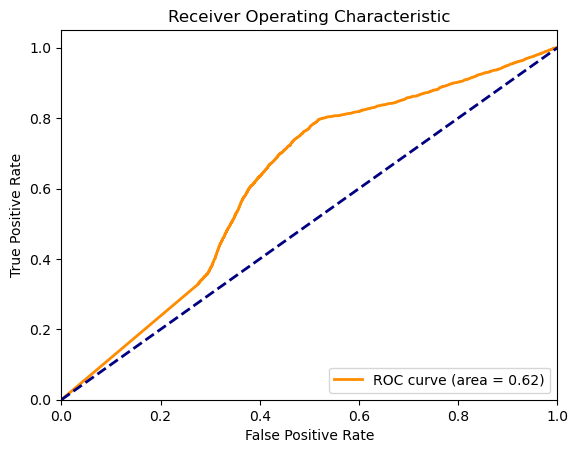

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have your model predictions (y_pred_proba) and true labels (y_true) 

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(data_test.y.cpu().numpy(), probs.cpu().numpy()) 

# Calculate AUC score
auc_score = roc_auc_score(data_test.y.cpu().numpy(), probs.cpu().numpy())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

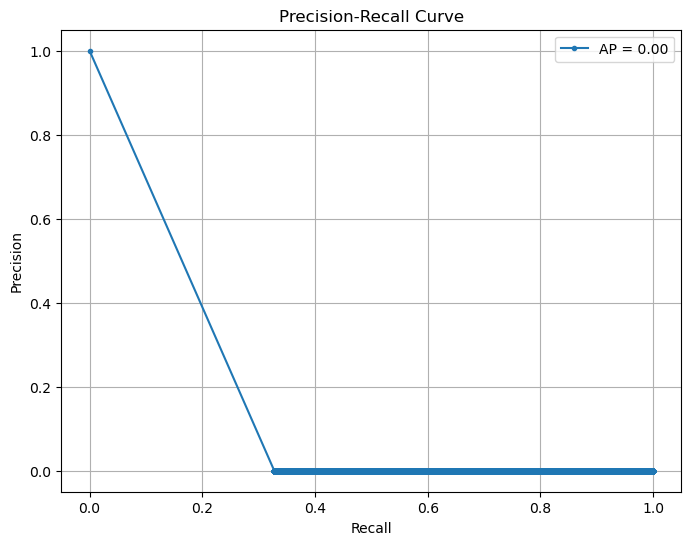

In [22]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(data_test.y.cpu().numpy(), probs.cpu().numpy())
# Compute average precision score
avg_precision = average_precision_score(data_test.y.cpu().numpy(), probs.cpu().numpy())

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()